In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
sys.path.append("/export/raid1/home/styvesg/code/")

import nsd_gnet8x.src.numpy_utility as pnu
from nsd_gnet8x.src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from nsd_gnet8x.src.config import *

from src.utility import *
from src.sampler import *

%matplotlib inline

In [3]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:2") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 4
device#: 0
device name: NVIDIA A100-PCIE-40GB

torch: 1.10.2+cu113
cuda:  11.3
cudnn: 8200
dtype: torch.float32


In [4]:
output_dir = root_dir + 'output/'

stim_dir = root_dir+'../../data/nsd/stims/'
voxel_dir = root_dir+'../../data/nsd/voxels/'

exp_design_file = root_dir+"../../data/nsd/nsd_expdesign.mat"

# Reload stim and labels

In [5]:
subjects = [1,2,3,4,5,6,7,8]

In [91]:
from nsd_gnet8x.src.load_nsd import image_feature_fn

stim_data = {}
for s in subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_224.h5py"%s, 'r')
    stim_data[s] = image_feature_fn(np.copy(image_data_set['stimuli']))
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', stim_data[s].shape, ', dtype:', stim_data[s].dtype, ', value range:',\
           np.min(stim_data[s][0]), np.max(stim_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 224, 224) , dtype: float32 , value range: 0.0 1.0
--------  subject 2  -------
block size: (10000, 3, 224, 224) , dtype: float32 , value range: 0.0 1.0
--------  subject 3  -------
block size: (10000, 3, 224, 224) , dtype: float32 , value range: 0.0 1.0
--------  subject 4  -------
block size: (10000, 3, 224, 224) , dtype: float32 , value range: 0.0 1.0
--------  subject 5  -------
block size: (10000, 3, 224, 224) , dtype: float32 , value range: 0.0 1.0
--------  subject 6  -------
block size: (10000, 3, 224, 224) , dtype: float32 , value range: 0.0 1.0
--------  subject 7  -------
block size: (10000, 3, 224, 224) , dtype: float32 , value range: 0.0 1.0
--------  subject 8  -------
block size: (10000, 3, 224, 224) , dtype: float32 , value range: 0.0 1.0


In [92]:
cat_data = {}
for s in subjects: 
    cat_data_set = h5py.File(stim_dir + "S%d_supercategory_227.h5py"%s, 'r')
    cat_data[s] = embed_dict({s: np.copy(d) for s,d in cat_data_set.items()})
    cat_data_set.close()
    print ('--------  subject %d  -------' % s)
    print (cat_data[s].keys())
    #print ('block size:', stim_data[s].shape, ', dtype:', stim_data[s].dtype, ', value range:',\
    #       np.min(stim_data[s][0]), np.max(stim_data[s][0]))

--------  subject 1  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 2  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 3  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 4  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 5  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 6  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 7  -------
dict_keys(['label_count', 'label_map', 'labels'])
--------  subject 8  -------
dict_keys(['label_count', 'label_map', 'labels'])


## Things supercategory: outdoor food indoor appliance kitchen sports person animal vehicle accessory electronic furniture

In [93]:
thing_label_index = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
thing_labelmap = {int(i): ('%s' % cat_data[1]['label_map']['%d'%i])[2:-1] for i in thing_label_index}

In [94]:
print (thing_labelmap)

{0: 'appliance', 1: 'accessory', 2: 'kitchen', 3: 'furniture', 4: 'indoor', 5: 'outdoor', 6: 'vehicle', 7: 'electronic', 8: 'sports', 9: 'food', 10: 'person', 11: 'animal'}


In [95]:
things_mh = {s: np.zeros(shape=(len(cat_data[s]['labels']), len(thing_label_index))) for s in subjects}
for s in subjects:
    for k,lim in enumerate(cat_data[s]['labels']):
        uni = np.unique(lim)
        uni_thing = intersection(uni, thing_label_index)
        things_mh[s][k, uni_thing] = 1 # this only works because the index are already a minimal set starting at zero

In [96]:
# there needs to be some filtering for incomplete samples
print ( things_mh[1].shape)

(10000, 12)


Minimum #samples = 686


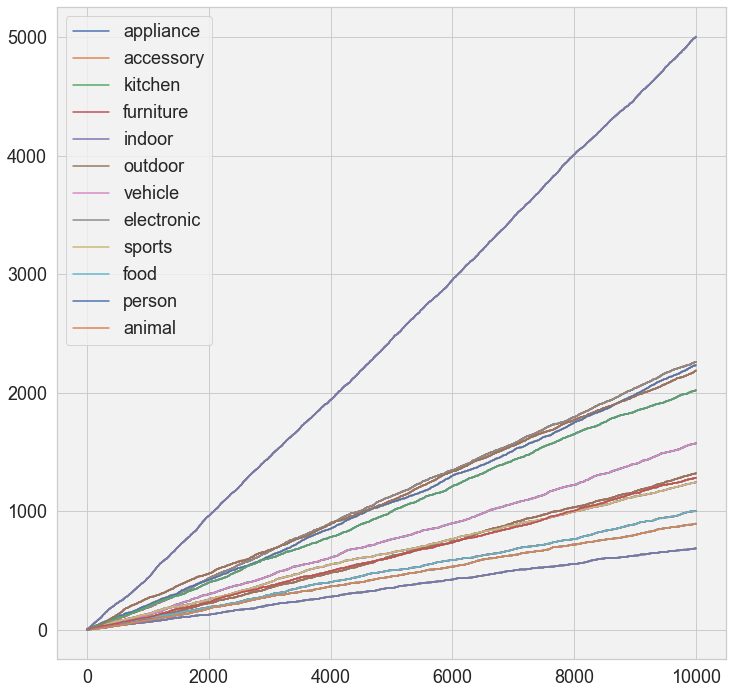

In [97]:
plt.figure(figsize=(12,12))
ymin = np.inf
for s in subjects:
    for k in thing_label_index:
        y = np.cumsum(things_mh[1][:,k], axis=0)
        if y[-1]<ymin:
            ymin = y[-1]
        plt.plot(y, label=thing_labelmap[k] if s==1 else None)
plt.legend(loc='upper left')
print ('Minimum #samples = %d'%ymin)

Main label:  person


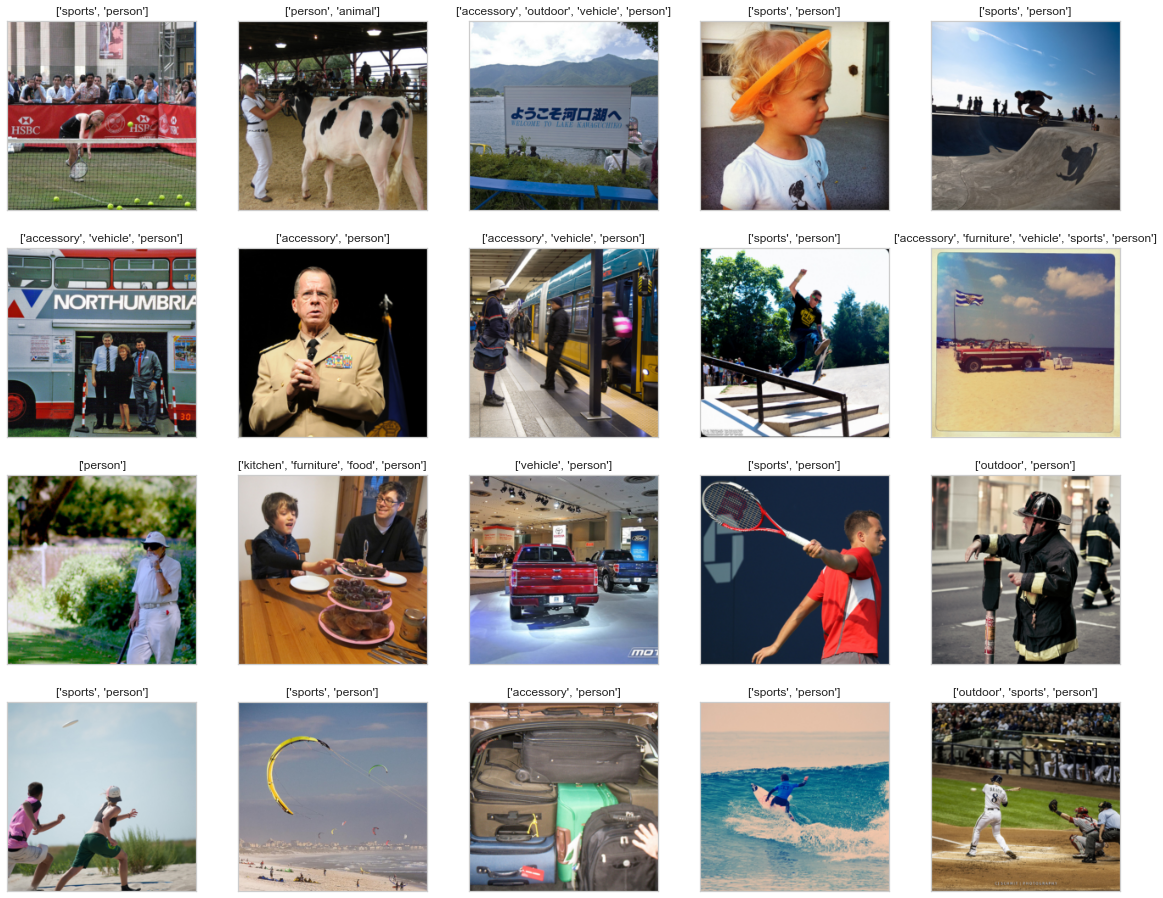

In [98]:
subj = 1
a_thing = 10
n_start = 0
n_img = 20
n_row = 4
print ('Main label: ', thing_labelmap[a_thing])
thing_sample_indices = get_n_random_thing_samples(things_mh, subj, a_thing, 100)
plt.figure(figsize=(4*int(np.ceil(float(n_img)/n_row)), 4*n_row))
for k,i in enumerate(range(n_start, n_start+n_img)):
    j = thing_sample_indices[i]
    
    plt.subplot(n_row, int(np.ceil(float(n_img)/n_row)), k+1)
    plt.imshow(stim_data[subj][j].transpose(1,2,0))
    plt.grid(False)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    
    im_label = thing_label_index[things_mh[subj][j].astype(bool)]
    plt.title([thing_labelmap[lab] for lab in im_label], fontsize=12)

# Network trained parameter source

In [99]:
def get_value(_x):
    return np.copy(_x.data.cpu().numpy())
def set_value(_x, x):
    _x.data.copy_(T.from_numpy(x))

def iterate_range(start, length, batchsize):
    batch_count = int(length // batchsize )
    residual = int(length % batchsize)
    for i in range(batch_count):
        yield range(start+i*batchsize, start+(i+1)*batchsize),batchsize
    if(residual>0):
        yield range(start+batch_count*batchsize,start+length),residual 

# Alexnet

In [137]:
from nsd_gnet8x.src.torch_feature_space import fmapper, analyse_net
from torchvision.models import alexnet

model_name = 'alexnet-rc'

net = alexnet(pretrained=True).to(device)
net_dict = analyse_net(net, quiet=True)

_x = torch.tensor(stim_data[1][:100]).to(device) # the input variable.
_fmaps_fn = fmapper(net_dict, [2, 4, 7, 9, 11, 17, 20, 21]).to(device)
_fmaps = _fmaps_fn(_x)    

In [138]:
from src.sampler import extract_fmaps_embedding

 # pretrained=False, shuffle=True, WORKS
 # pretrained=True, shuffle=True, DOESNT WORK (leads to manifold collapse)

feature_embs, labels = \
    extract_fmaps_embedding(net, _fmaps_fn, stim_data=stim_data, label_data=things_mh, \
                            batchsize=100, n_samples=9, rand_sampling_dim=20000, rand_proj_dim=2000, \
                            zscore=True, shuffle_params=False, device=device)

  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([64, 27, 27]) --> 46656 --> 20000
torch.Size([192, 27, 27]) --> 139968 --> 20000
torch.Size([384, 13, 13]) --> 64896 --> 20000
torch.Size([256, 13, 13]) --> 43264 --> 20000
torch.Size([256, 13, 13]) --> 43264 --> 20000
torch.Size([4096, 1, 1]) --> 4096
torch.Size([4096, 1, 1]) --> 4096
torch.Size([1000, 1, 1]) --> 1000


100%|██████████| 9/9 [03:27<00:00, 23.06s/it]


In [139]:
from src.geometry import calculate_manifolds_directions, calculate_manifolds_SNR

manifold_dirs = calculate_manifolds_directions(feature_embs, labels=labels, P=580)
manifold_SNR = calculate_manifolds_SNR(manifold_dirs, m=5)

100%|██████████| 12/12 [00:00<00:00, 15.46it/s]


In [25]:
save_stuff( output_dir + '%s_zmanifold_SNR_rc'%model_name, flatten_dict(manifold_SNR))

saved 0.Sign.0 in h5py file
saved 0.Sign.1 in h5py file
saved 0.Sign.2 in h5py file
saved 0.Sign.3 in h5py file
saved 0.Sign.4 in h5py file
saved 0.Sign.5 in h5py file
saved 0.Sign.6 in h5py file
saved 0.Sign.7 in h5py file
saved 0.Bias.0 in h5py file
saved 0.Bias.1 in h5py file
saved 0.Bias.2 in h5py file
saved 0.Bias.3 in h5py file
saved 0.Bias.4 in h5py file
saved 0.Bias.5 in h5py file
saved 0.Bias.6 in h5py file
saved 0.Bias.7 in h5py file
saved 0.Nsa.0 in h5py file
saved 0.Nsa.1 in h5py file
saved 0.Nsa.2 in h5py file
saved 0.Nsa.3 in h5py file
saved 0.Nsa.4 in h5py file
saved 0.Nsa.5 in h5py file
saved 0.Nsa.6 in h5py file
saved 0.Nsa.7 in h5py file
saved 0.Nsb.0 in h5py file
saved 0.Nsb.1 in h5py file
saved 0.Nsb.2 in h5py file
saved 0.Nsb.3 in h5py file
saved 0.Nsb.4 in h5py file
saved 0.Nsb.5 in h5py file
saved 0.Nsb.6 in h5py file
saved 0.Nsb.7 in h5py file
saved 0.Nss.0 in h5py file
saved 0.Nss.1 in h5py file
saved 0.Nss.2 in h5py file
saved 0.Nss.3 in h5py file
saved 0.Nss.

saved 5.SNR.0 in h5py file
saved 5.SNR.1 in h5py file
saved 5.SNR.2 in h5py file
saved 5.SNR.3 in h5py file
saved 5.SNR.4 in h5py file
saved 5.SNR.5 in h5py file
saved 5.SNR.6 in h5py file
saved 5.SNR.7 in h5py file
saved 5.m in h5py file
saved 5.P in h5py file
saved 6.Sign.0 in h5py file
saved 6.Sign.1 in h5py file
saved 6.Sign.2 in h5py file
saved 6.Sign.3 in h5py file
saved 6.Sign.4 in h5py file
saved 6.Sign.5 in h5py file
saved 6.Sign.6 in h5py file
saved 6.Sign.7 in h5py file
saved 6.Bias.0 in h5py file
saved 6.Bias.1 in h5py file
saved 6.Bias.2 in h5py file
saved 6.Bias.3 in h5py file
saved 6.Bias.4 in h5py file
saved 6.Bias.5 in h5py file
saved 6.Bias.6 in h5py file
saved 6.Bias.7 in h5py file
saved 6.Nsa.0 in h5py file
saved 6.Nsa.1 in h5py file
saved 6.Nsa.2 in h5py file
saved 6.Nsa.3 in h5py file
saved 6.Nsa.4 in h5py file
saved 6.Nsa.5 in h5py file
saved 6.Nsa.6 in h5py file
saved 6.Nsa.7 in h5py file
saved 6.Nsb.0 in h5py file
saved 6.Nsb.1 in h5py file
saved 6.Nsb.2 in h5p

In [140]:
plot_roi = np.arange(len(_fmaps))

from matplotlib import cm
subj_cmap = {k: cm.get_cmap('rainbow', n_samples+1)(k+1) for k in range(n_samples)}

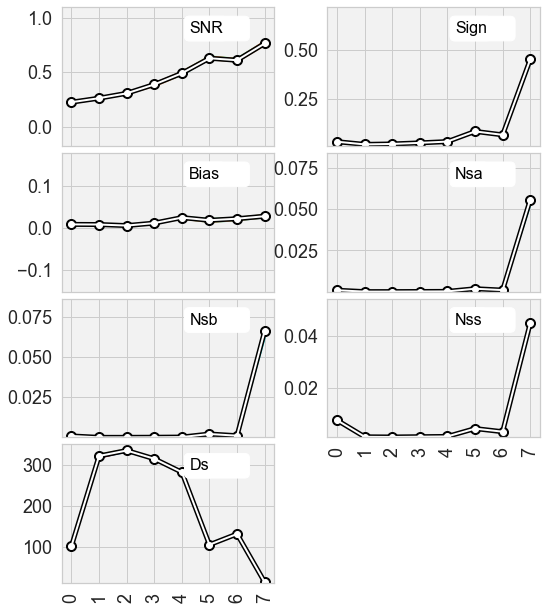

In [141]:
from src.plots import plot_SNR_summary

fig = plt.figure(figsize=(8, 10))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.98, top=.95, wspace=0.25, hspace=0.05)
plot_SNR_summary(manifold_SNR, subj_cmap, plot_roi, perc_cutoff=25, fs=16)

---
# VGG19

In [26]:
from nsd_gnet8x.src.torch_feature_space import fmapper, analyse_net
import torch as T
from torchvision.models import vgg19

model_name = 'vgg19-rc'

net = vgg19(pretrained=True).to(device)
net_dict = analyse_net(net, quiet=False)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3)

In [ ]:
_x = torch.tensor(stim_data[1][:100]).to(device) # the input variable.
_fmaps_fn = fmapper(net_dict, [1, 3, 6, 8, 11, 13, 15, 17, 20, 22, 24, 26, 29, 31, 33, 35, 40, 43, 45]).to(device)
_fmaps = _fmaps_fn(_x) 

In [ ]:
from src.sampler import extract_fmaps_embedding

feature_embs, labels = \
    extract_fmaps_embedding(net, _fmaps_fn, stim_data=stim_data, label_data=things_mh, \
                            batchsize=100, n_samples=9, rand_sampling_dim=20000, rand_proj_dim=2000, \
                            zscore=True, shuffle_params=False, device=device)

In [19]:
from src.geometry import calculate_manifolds_directions, calculate_manifolds_SNR

manifold_dirs = calculate_manifolds_directions(feature_embs, labels=labels, P=580)
manifold_SNR = calculate_manifolds_SNR(manifold_dirs, m=5)

100%|██████████| 12/12 [00:00<00:00, 13.96it/s]


In [25]:
save_stuff( output_dir + '%s_zmanifold_SNR_rc'%model_name, flatten_dict(manifold_SNR))

saved 0.Sign.0 in h5py file
saved 0.Sign.1 in h5py file
saved 0.Sign.2 in h5py file
saved 0.Sign.3 in h5py file
saved 0.Sign.4 in h5py file
saved 0.Sign.5 in h5py file
saved 0.Sign.6 in h5py file
saved 0.Sign.7 in h5py file
saved 0.Bias.0 in h5py file
saved 0.Bias.1 in h5py file
saved 0.Bias.2 in h5py file
saved 0.Bias.3 in h5py file
saved 0.Bias.4 in h5py file
saved 0.Bias.5 in h5py file
saved 0.Bias.6 in h5py file
saved 0.Bias.7 in h5py file
saved 0.Nsa.0 in h5py file
saved 0.Nsa.1 in h5py file
saved 0.Nsa.2 in h5py file
saved 0.Nsa.3 in h5py file
saved 0.Nsa.4 in h5py file
saved 0.Nsa.5 in h5py file
saved 0.Nsa.6 in h5py file
saved 0.Nsa.7 in h5py file
saved 0.Nsb.0 in h5py file
saved 0.Nsb.1 in h5py file
saved 0.Nsb.2 in h5py file
saved 0.Nsb.3 in h5py file
saved 0.Nsb.4 in h5py file
saved 0.Nsb.5 in h5py file
saved 0.Nsb.6 in h5py file
saved 0.Nsb.7 in h5py file
saved 0.Nss.0 in h5py file
saved 0.Nss.1 in h5py file
saved 0.Nss.2 in h5py file
saved 0.Nss.3 in h5py file
saved 0.Nss.

saved 5.SNR.0 in h5py file
saved 5.SNR.1 in h5py file
saved 5.SNR.2 in h5py file
saved 5.SNR.3 in h5py file
saved 5.SNR.4 in h5py file
saved 5.SNR.5 in h5py file
saved 5.SNR.6 in h5py file
saved 5.SNR.7 in h5py file
saved 5.m in h5py file
saved 5.P in h5py file
saved 6.Sign.0 in h5py file
saved 6.Sign.1 in h5py file
saved 6.Sign.2 in h5py file
saved 6.Sign.3 in h5py file
saved 6.Sign.4 in h5py file
saved 6.Sign.5 in h5py file
saved 6.Sign.6 in h5py file
saved 6.Sign.7 in h5py file
saved 6.Bias.0 in h5py file
saved 6.Bias.1 in h5py file
saved 6.Bias.2 in h5py file
saved 6.Bias.3 in h5py file
saved 6.Bias.4 in h5py file
saved 6.Bias.5 in h5py file
saved 6.Bias.6 in h5py file
saved 6.Bias.7 in h5py file
saved 6.Nsa.0 in h5py file
saved 6.Nsa.1 in h5py file
saved 6.Nsa.2 in h5py file
saved 6.Nsa.3 in h5py file
saved 6.Nsa.4 in h5py file
saved 6.Nsa.5 in h5py file
saved 6.Nsa.6 in h5py file
saved 6.Nsa.7 in h5py file
saved 6.Nsb.0 in h5py file
saved 6.Nsb.1 in h5py file
saved 6.Nsb.2 in h5p

---
## ResNet50

In [ ]:
import torch as T
from nsd_gnet8x.src.torch_feature_space import fmapper, analyse_net
from torchvision.models import resnet50

model_name = 'resnet50-R-rc'

net = resnet50(pretrained=True).to(device)  # pretrained argument is now deprecated method
net_dict = analyse_net(net, quiet=True)

_x = torch.tensor(stim_data[subj][:100]).to(device) # the input variable.
_fmaps_fn = fmapper(net_dict, [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22]).to(device)
_fmaps = _fmaps_fn(_x)

In [ ]:
from src.sampler import extract_fmaps_embedding

feature_embs, labels = \
    extract_fmaps_embedding(net, _fmaps_fn, stim_data=stim_data, label_data=things_mh, \
                            batchsize=100, n_samples=9, rand_sampling_dim=20000, rand_proj_dim=2000, \
                            zscore=True, shuffle_params=True, device=device)

In [54]:
from src.geometry import calculate_manifolds_directions, calculate_manifolds_SNR

manifold_dirs = calculate_manifolds_directions(feature_embs, labels=labels, P=580)
manifold_SNR = calculate_manifolds_SNR(manifold_dirs, m=5)

100%|██████████| 12/12 [00:00<00:00, 15.48it/s]


In [55]:
save_stuff( output_dir + '%s_zmanifold_SNR_rc'%model_name, flatten_dict(manifold_SNR))

saved 0.Sign.0 in h5py file
saved 0.Sign.1 in h5py file
saved 0.Sign.2 in h5py file
saved 0.Sign.3 in h5py file
saved 0.Sign.4 in h5py file
saved 0.Sign.5 in h5py file
saved 0.Sign.6 in h5py file
saved 0.Sign.7 in h5py file
saved 0.Sign.8 in h5py file
saved 0.Sign.9 in h5py file
saved 0.Sign.10 in h5py file
saved 0.Sign.11 in h5py file
saved 0.Sign.12 in h5py file
saved 0.Sign.13 in h5py file
saved 0.Sign.14 in h5py file
saved 0.Sign.15 in h5py file
saved 0.Sign.16 in h5py file
saved 0.Sign.17 in h5py file
saved 0.Bias.0 in h5py file
saved 0.Bias.1 in h5py file
saved 0.Bias.2 in h5py file
saved 0.Bias.3 in h5py file
saved 0.Bias.4 in h5py file
saved 0.Bias.5 in h5py file
saved 0.Bias.6 in h5py file
saved 0.Bias.7 in h5py file
saved 0.Bias.8 in h5py file
saved 0.Bias.9 in h5py file
saved 0.Bias.10 in h5py file
saved 0.Bias.11 in h5py file
saved 0.Bias.12 in h5py file
saved 0.Bias.13 in h5py file
saved 0.Bias.14 in h5py file
saved 0.Bias.15 in h5py file
saved 0.Bias.16 in h5py file
saved

saved 4.SNR.1 in h5py file
saved 4.SNR.2 in h5py file
saved 4.SNR.3 in h5py file
saved 4.SNR.4 in h5py file
saved 4.SNR.5 in h5py file
saved 4.SNR.6 in h5py file
saved 4.SNR.7 in h5py file
saved 4.SNR.8 in h5py file
saved 4.SNR.9 in h5py file
saved 4.SNR.10 in h5py file
saved 4.SNR.11 in h5py file
saved 4.SNR.12 in h5py file
saved 4.SNR.13 in h5py file
saved 4.SNR.14 in h5py file
saved 4.SNR.15 in h5py file
saved 4.SNR.16 in h5py file
saved 4.SNR.17 in h5py file
saved 4.m in h5py file
saved 4.P in h5py file
saved 5.Sign.0 in h5py file
saved 5.Sign.1 in h5py file
saved 5.Sign.2 in h5py file
saved 5.Sign.3 in h5py file
saved 5.Sign.4 in h5py file
saved 5.Sign.5 in h5py file
saved 5.Sign.6 in h5py file
saved 5.Sign.7 in h5py file
saved 5.Sign.8 in h5py file
saved 5.Sign.9 in h5py file
saved 5.Sign.10 in h5py file
saved 5.Sign.11 in h5py file
saved 5.Sign.12 in h5py file
saved 5.Sign.13 in h5py file
saved 5.Sign.14 in h5py file
saved 5.Sign.15 in h5py file
saved 5.Sign.16 in h5py file
save

In [56]:
plot_roi = np.arange(len(_fmaps))

from matplotlib import cm
subj_cmap = {k: cm.get_cmap('rainbow', n_samples+1)(k+1) for k in range(n_samples)}

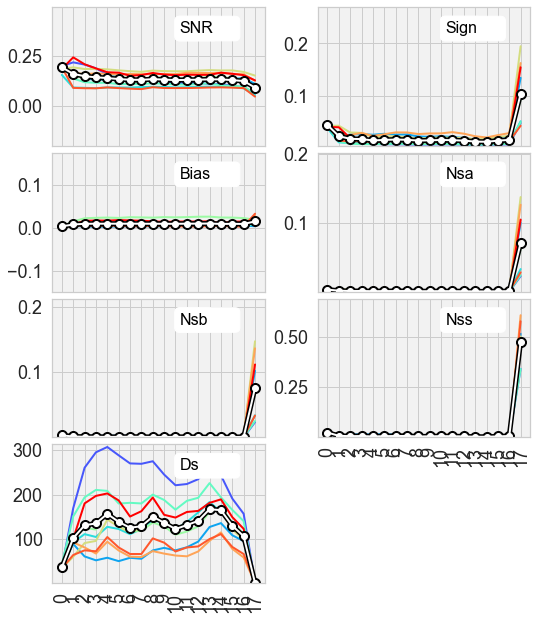

In [57]:
from src.plots import plot_SNR_summary

fig = plt.figure(figsize=(8, 10))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.98, top=.95, wspace=0.25, hspace=0.05)
plot_SNR_summary(manifold_SNR, subj_cmap, plot_roi, perc_cutoff=25, fs=16)

---
## ResNet50 - simCLR pretrained weights

## Convert to torchvision format
This implementation used a wrapper around the torchvision resnet50 arch. So the saved checkpoint has one additional level

In [100]:
# source: https://github.com/AndrewAtanov/simclr-pytorch/blob/master/README.md
ckpt = torch.load('/export/raid1/home/styvesg/data/pretrained_models/resnet50_imagenet_bs2k_epochs600.pth.tar', map_location=device)

In [101]:
from collections import OrderedDict
rn50_ckpt = OrderedDict([])
for k,v in ckpt['state_dict'].items():
    if 'convnet.'==k[:8]:
        rn50_ckpt[k[8:]] = v

## Architecture

In [102]:
from nsd_gnet8x.src.torch_feature_space import fmapper, analyse_net
from torchvision.models import resnet50

model_name = 'resnet50-simCLR-rc'

net = resnet50(pretrained=True).to(device)  # pretrained argument is now deprecated method
net.load_state_dict(rn50_ckpt)
net_dict = analyse_net(net, quiet=True)
_fmaps_fn = fmapper(net_dict, [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22]).to(device)

In [ ]:
from src.sampler import extract_fmaps_embedding

feature_embs, labels = \
    extract_fmaps_embedding(net, _fmaps_fn, stim_data=stim_data, label_data=things_mh, \
                            batchsize=100, n_samples=9, rand_sampling_dim=20000, rand_proj_dim=2000, \
                            zscore=True, shuffle_params=False, device=device)

In [104]:
from src.geometry import calculate_manifolds_directions, calculate_manifolds_SNR

manifold_dirs = calculate_manifolds_directions(feature_embs, labels=labels, P=580)
manifold_SNR = calculate_manifolds_SNR(manifold_dirs, m=5)

100%|██████████| 12/12 [00:00<00:00, 15.44it/s]


100%|██████████| 12/12 [00:00<00:00, 15.39it/s]


In [105]:
save_stuff( output_dir + '%s_zmanifold_SNR_rc'%model_name, flatten_dict(manifold_SNR))

saved 0.Sign.0 in h5py file
saved 0.Sign.1 in h5py file
saved 0.Sign.2 in h5py file
saved 0.Sign.3 in h5py file
saved 0.Sign.4 in h5py file
saved 0.Sign.5 in h5py file
saved 0.Sign.6 in h5py file
saved 0.Sign.7 in h5py file
saved 0.Sign.8 in h5py file
saved 0.Sign.9 in h5py file
saved 0.Sign.10 in h5py file
saved 0.Sign.11 in h5py file
saved 0.Sign.12 in h5py file
saved 0.Sign.13 in h5py file
saved 0.Sign.14 in h5py file
saved 0.Sign.15 in h5py file
saved 0.Sign.16 in h5py file
saved 0.Sign.17 in h5py file
saved 0.Bias.0 in h5py file
saved 0.Bias.1 in h5py file
saved 0.Bias.2 in h5py file
saved 0.Bias.3 in h5py file
saved 0.Bias.4 in h5py file
saved 0.Bias.5 in h5py file
saved 0.Bias.6 in h5py file
saved 0.Bias.7 in h5py file
saved 0.Bias.8 in h5py file
saved 0.Bias.9 in h5py file
saved 0.Bias.10 in h5py file
saved 0.Bias.11 in h5py file
saved 0.Bias.12 in h5py file
saved 0.Bias.13 in h5py file
saved 0.Bias.14 in h5py file
saved 0.Bias.15 in h5py file
saved 0.Bias.16 in h5py file
saved

saved 5.Nsa.15 in h5py file
saved 5.Nsa.16 in h5py file
saved 5.Nsa.17 in h5py file
saved 5.Nsb.0 in h5py file
saved 5.Nsb.1 in h5py file
saved 5.Nsb.2 in h5py file
saved 5.Nsb.3 in h5py file
saved 5.Nsb.4 in h5py file
saved 5.Nsb.5 in h5py file
saved 5.Nsb.6 in h5py file
saved 5.Nsb.7 in h5py file
saved 5.Nsb.8 in h5py file
saved 5.Nsb.9 in h5py file
saved 5.Nsb.10 in h5py file
saved 5.Nsb.11 in h5py file
saved 5.Nsb.12 in h5py file
saved 5.Nsb.13 in h5py file
saved 5.Nsb.14 in h5py file
saved 5.Nsb.15 in h5py file
saved 5.Nsb.16 in h5py file
saved 5.Nsb.17 in h5py file
saved 5.Nss.0 in h5py file
saved 5.Nss.1 in h5py file
saved 5.Nss.2 in h5py file
saved 5.Nss.3 in h5py file
saved 5.Nss.4 in h5py file
saved 5.Nss.5 in h5py file
saved 5.Nss.6 in h5py file
saved 5.Nss.7 in h5py file
saved 5.Nss.8 in h5py file
saved 5.Nss.9 in h5py file
saved 5.Nss.10 in h5py file
saved 5.Nss.11 in h5py file
saved 5.Nss.12 in h5py file
saved 5.Nss.13 in h5py file
saved 5.Nss.14 in h5py file
saved 5.Nss.

In [106]:
plot_roi = np.arange(len(_fmaps))

from matplotlib import cm
subj_cmap = {k: cm.get_cmap('rainbow', n_samples+1)(k+1) for k in range(n_samples)}

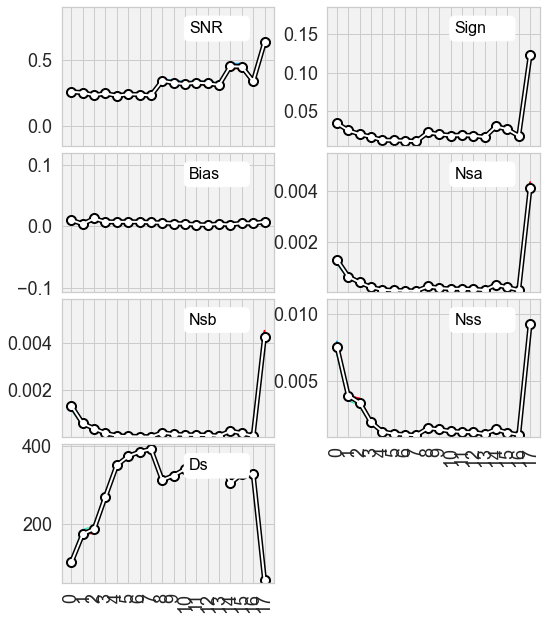

In [108]:
from src.plots import plot_SNR_summary

fig = plt.figure(figsize=(8, 10))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.98, top=.95, wspace=0.25, hspace=0.05)
plot_SNR_summary(manifold_SNR, subj_cmap, plot_roi, perc_cutoff=25, fs=16)

---
# SqueezeNet

In [114]:
import torch as T
from torchvision.models import squeezenet1_1
from nsd_gnet8x.src.torch_feature_space import fmapper, analyse_net

model_name = 'squeezenet-rc'

net = squeezenet1_1(pretrained=True).to(device) # SqueezeNet1_1_Weights.IMAGENET1K_V1
net_dict = analyse_net(net, quiet=False)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
1 ReLU(inplace=True)
2 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
3 Fire(
  (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
  (squeeze_activation): ReLU(inplace=True)
  (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
  (expand1x1_activation): ReLU(inplace=True)
  (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (expand3x3_activation): ReLU(inplace=True)
)
4 Fire(
  (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
  (squeeze_activation): ReLU(inplace=True)
  (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
  (expand1x1_activation): ReLU(inplace=True)
  (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (expand3x3_activation): ReLU(inplace=True)
)
5 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
6 Fire(
  (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))

In [115]:
_x = torch.tensor(stim_data[1][:100]).to(device) # the input variable.
_fmaps_fn = fmapper(net_dict, [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]).to(device)
_fmaps = _fmaps_fn(_x) 

In [132]:
from src.sampler import extract_fmaps_embedding

feature_embs, labels = \
    extract_fmaps_embedding(net, _fmaps_fn, stim_data=stim_data, label_data=things_mh, \
                            batchsize=100, n_samples=9, rand_sampling_dim=20000, rand_proj_dim=2000, \
                            zscore=True, shuffle_params=False, device=device)

  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([128, 55, 55]) --> 387200 --> 20000
torch.Size([128, 55, 55]) --> 387200 --> 20000
torch.Size([128, 27, 27]) --> 93312 --> 20000
torch.Size([256, 27, 27]) --> 186624 --> 20000
torch.Size([256, 27, 27]) --> 186624 --> 20000
torch.Size([256, 13, 13]) --> 43264 --> 20000
torch.Size([384, 13, 13]) --> 64896 --> 20000
torch.Size([384, 13, 13]) --> 64896 --> 20000
torch.Size([512, 13, 13]) --> 86528 --> 20000
torch.Size([512, 13, 13]) --> 86528 --> 20000
torch.Size([1000, 13, 13]) --> 169000 --> 20000


100%|██████████| 9/9 [06:27<00:00, 43.11s/it]


In [133]:
from src.geometry import calculate_manifolds_directions, calculate_manifolds_SNR

manifold_dirs = calculate_manifolds_directions(feature_embs, labels=labels, P=580)
manifold_SNR = calculate_manifolds_SNR(manifold_dirs, m=5)

100%|██████████| 12/12 [00:00<00:00, 15.22it/s]


100%|██████████| 12/12 [00:00<00:00, 15.24it/s]


In [86]:
save_stuff( output_dir + '%s_zmanifold_SNR_rc'%model_name, flatten_dict(manifold_SNR))

saved 0.Sign.0 in h5py file
saved 0.Sign.1 in h5py file
saved 0.Sign.2 in h5py file
saved 0.Sign.3 in h5py file
saved 0.Sign.4 in h5py file
saved 0.Sign.5 in h5py file
saved 0.Sign.6 in h5py file
saved 0.Sign.7 in h5py file
saved 0.Sign.8 in h5py file
saved 0.Sign.9 in h5py file
saved 0.Sign.10 in h5py file
saved 0.Bias.0 in h5py file
saved 0.Bias.1 in h5py file
saved 0.Bias.2 in h5py file
saved 0.Bias.3 in h5py file
saved 0.Bias.4 in h5py file
saved 0.Bias.5 in h5py file
saved 0.Bias.6 in h5py file
saved 0.Bias.7 in h5py file
saved 0.Bias.8 in h5py file
saved 0.Bias.9 in h5py file
saved 0.Bias.10 in h5py file
saved 0.Nsa.0 in h5py file
saved 0.Nsa.1 in h5py file
saved 0.Nsa.2 in h5py file
saved 0.Nsa.3 in h5py file
saved 0.Nsa.4 in h5py file
saved 0.Nsa.5 in h5py file
saved 0.Nsa.6 in h5py file
saved 0.Nsa.7 in h5py file
saved 0.Nsa.8 in h5py file
saved 0.Nsa.9 in h5py file
saved 0.Nsa.10 in h5py file
saved 0.Nsb.0 in h5py file
saved 0.Nsb.1 in h5py file
saved 0.Nsb.2 in h5py file
sav

saved 8.Nss.7 in h5py file
saved 8.Nss.8 in h5py file
saved 8.Nss.9 in h5py file
saved 8.Nss.10 in h5py file
saved 8.Ds.0 in h5py file
saved 8.Ds.1 in h5py file
saved 8.Ds.2 in h5py file
saved 8.Ds.3 in h5py file
saved 8.Ds.4 in h5py file
saved 8.Ds.5 in h5py file
saved 8.Ds.6 in h5py file
saved 8.Ds.7 in h5py file
saved 8.Ds.8 in h5py file
saved 8.Ds.9 in h5py file
saved 8.Ds.10 in h5py file
saved 8.SNR.0 in h5py file
saved 8.SNR.1 in h5py file
saved 8.SNR.2 in h5py file
saved 8.SNR.3 in h5py file
saved 8.SNR.4 in h5py file
saved 8.SNR.5 in h5py file
saved 8.SNR.6 in h5py file
saved 8.SNR.7 in h5py file
saved 8.SNR.8 in h5py file
saved 8.SNR.9 in h5py file
saved 8.SNR.10 in h5py file
saved 8.m in h5py file
saved 8.P in h5py file


In [134]:
plot_roi = np.arange(len(_fmaps))

from matplotlib import cm
subj_cmap = {k: cm.get_cmap('rainbow', n_samples+1)(k+1) for k in range(n_samples)}

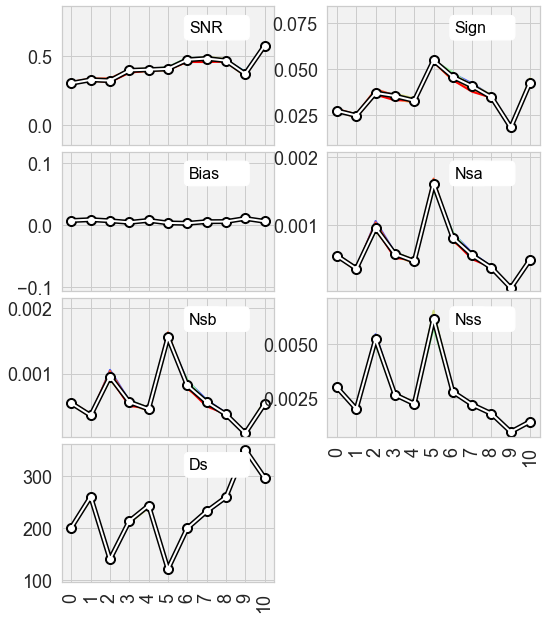

In [135]:
from src.plots import plot_SNR_summary

fig = plt.figure(figsize=(8, 10))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.98, top=.95, wspace=0.25, hspace=0.05)
plot_SNR_summary(manifold_SNR, subj_cmap, plot_roi, perc_cutoff=25, fs=16)